#Assessment I - Image Classification with Convolutional Neural Network

## Part A: Implementing Convolutional Neural Network from scratch.

### Libraries Installation and imports

In [ ]:
!pip install numpy matplotlib seaborn scikit-learn pillow tensorflow

In [13]:
# Importing Libraries
import os
import random
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.regularizers import l2


### Mounting Drive and loading dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/MyDrive/AL and ML/Assingment I/Car_Brand_Logos/Train'
test_dir = '/content/drive/MyDrive/AL and ML/Assingment I/Car_Brand_Logos/Test'

### Data Understanding, Analysis, Visualization and Cleaning

- What does the dataset represent? Provide a brief description.
  - The dataset represents car brand logos, categorized into 8 classes: Hyundai, Lexus, Mazda, Mercedes, Opel, Skoda, Toyota, and Volkswagen. It is available on Kaggle and was provided by Volkan Özdemir. (https://www.kaggle.com/datasets/volkandl/car-brand-logos/code).

- How many total images are in the dataset?
  - There are 2913 total images.

- What is the distribution of images across different classes?
  - the distribution of images across different classes are given below:

   * Hyundai: 302 images
   * Lexus: 301 images
   * Mazda: 317 images
   * Mercedes: 342 images
   * Opel: 301 images
   * Skoda: 314 images
   * Toyota: 306 images
   * Volkswagen: 330 images

- How is the dataset split into training and validation sets? Justify your choice.

  - The dataset is split into 80% for training and 20% for validation. This is a common practice in machine learning, as it provides a sufficient amount of data for the model to learn while reserving a portion to evaluate its performance and generalization capability on unseen data.

- What preprocessing techniques (e.g., resizing, normalization) were applied?
  1. Resizing:
    All images are resized to a fixed dimension defined by target_size using the target_size parameter in flow_from_directory().

  2. Normalization:
    All images are normalized by rescaling pixel values from [0, 255] to [0, 1] using rescale=1./255 in both the training and test datasets.

-  What data generators, if any, were used for preprocessing and augmentation?

  1. ImageDataGenerator was used:

  - For the training and validation datasets, train_datagen applies:

    - Rescaling

    - Data augmentation:

      - rotation_range=10

      - width_shift_range=0.05

      - height_shift_range=0.05

      - zoom_range=0.05

      - horizontal_flip=True

  - Validation split (20%) is handled via validation_split=0.2 and subset="training"/"validation".

  2. For the test dataset, test_datagen only applies rescaling (no augmentation)

-  If data augmentation was applied, provide visualizations of sample augmented images.

  - Visualization of data augmentation is provided below in the data augmentation and data distribution section

In [14]:
def total_images_through_classes(directory):
  """
  Counts the number of image files in each class subdirectory within the given directory.

  Args:
      directory: Path to the directory containing class subdirectories.

  Returns:
      dict: A dictionary where keys are class names and values are the count of images
            in each respective class directory.
  """
  class_totals = {}
  for class_name in os.listdir(directory):
      class_path = os.path.join(directory, class_name)
      if os.path.isdir(class_path):
          image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
          class_totals[class_name] = len(image_files)
  return class_totals

In [15]:
train_totals = total_images_through_classes(train_dir)
test_totals = total_images_through_classes(test_dir)

In [16]:
total_train_count = 0
total_test_count = 0
print("Training Images:")
print("Classes:")
for classs, count in train_totals.items():
    total_train_count += count
    print(f"'{classs}': {count} images")
print()
print("Test Images:")
print("Classes:")
for classs, count in test_totals.items():
    total_test_count += count
    print(f"'{classs}': {count} images")

print()
print(f"Total Training Images Count: {total_train_count}")
print(f"Total Test Images Count: {total_test_count}")
print(f"Total Images Count: {total_train_count + total_test_count}")

Training Images:
Classes:
'hyundai': 301 images
'lexus': 301 images
'mazda': 315 images
'mercedes': 341 images
'opel': 298 images
'volkswagen': 328 images
'skoda': 314 images
'toyota': 304 images

Test Images:
Classes:
'skoda': 50 images
'toyota': 50 images
'hyundai': 49 images
'volkswagen': 50 images
'mazda': 50 images
'opel': 50 images
'mercedes': 50 images
'lexus': 50 images

Total Training Images Count: 2502
Total Test Images Count: 399
Total Images Count: 2901


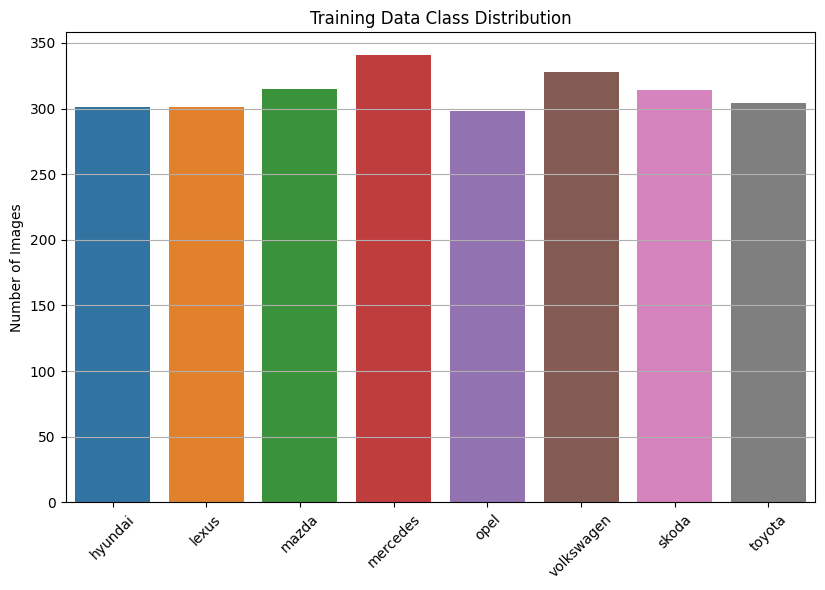

In [17]:
# Class distribution histogram
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=list(train_totals.keys()), y=list(train_totals.values()), hue=list(train_totals.keys()))
plt.title('Training Data Class Distribution')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

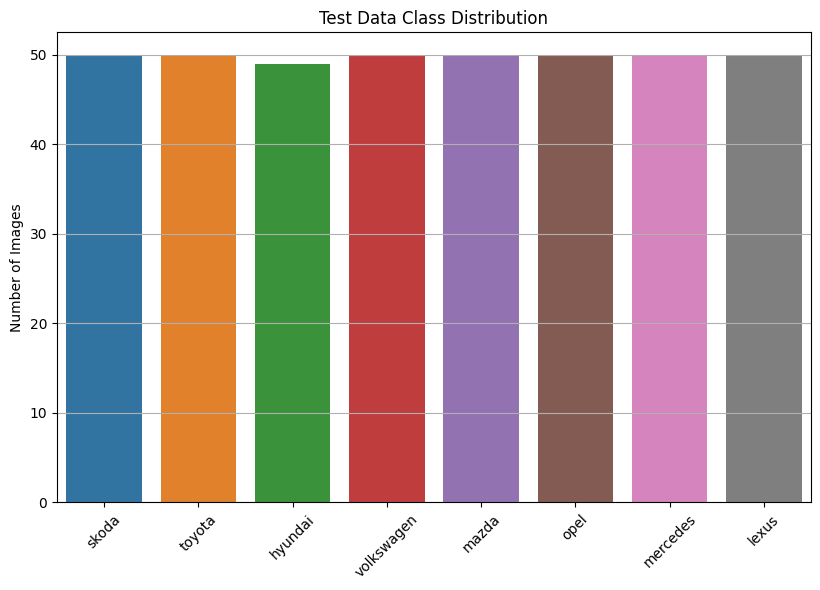

In [18]:
# Class distribution histogram
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 2)
sns.barplot(x=list(test_totals.keys()), y=list(test_totals.values()), hue=list(test_totals.keys()))
plt.title('Test Data Class Distribution')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

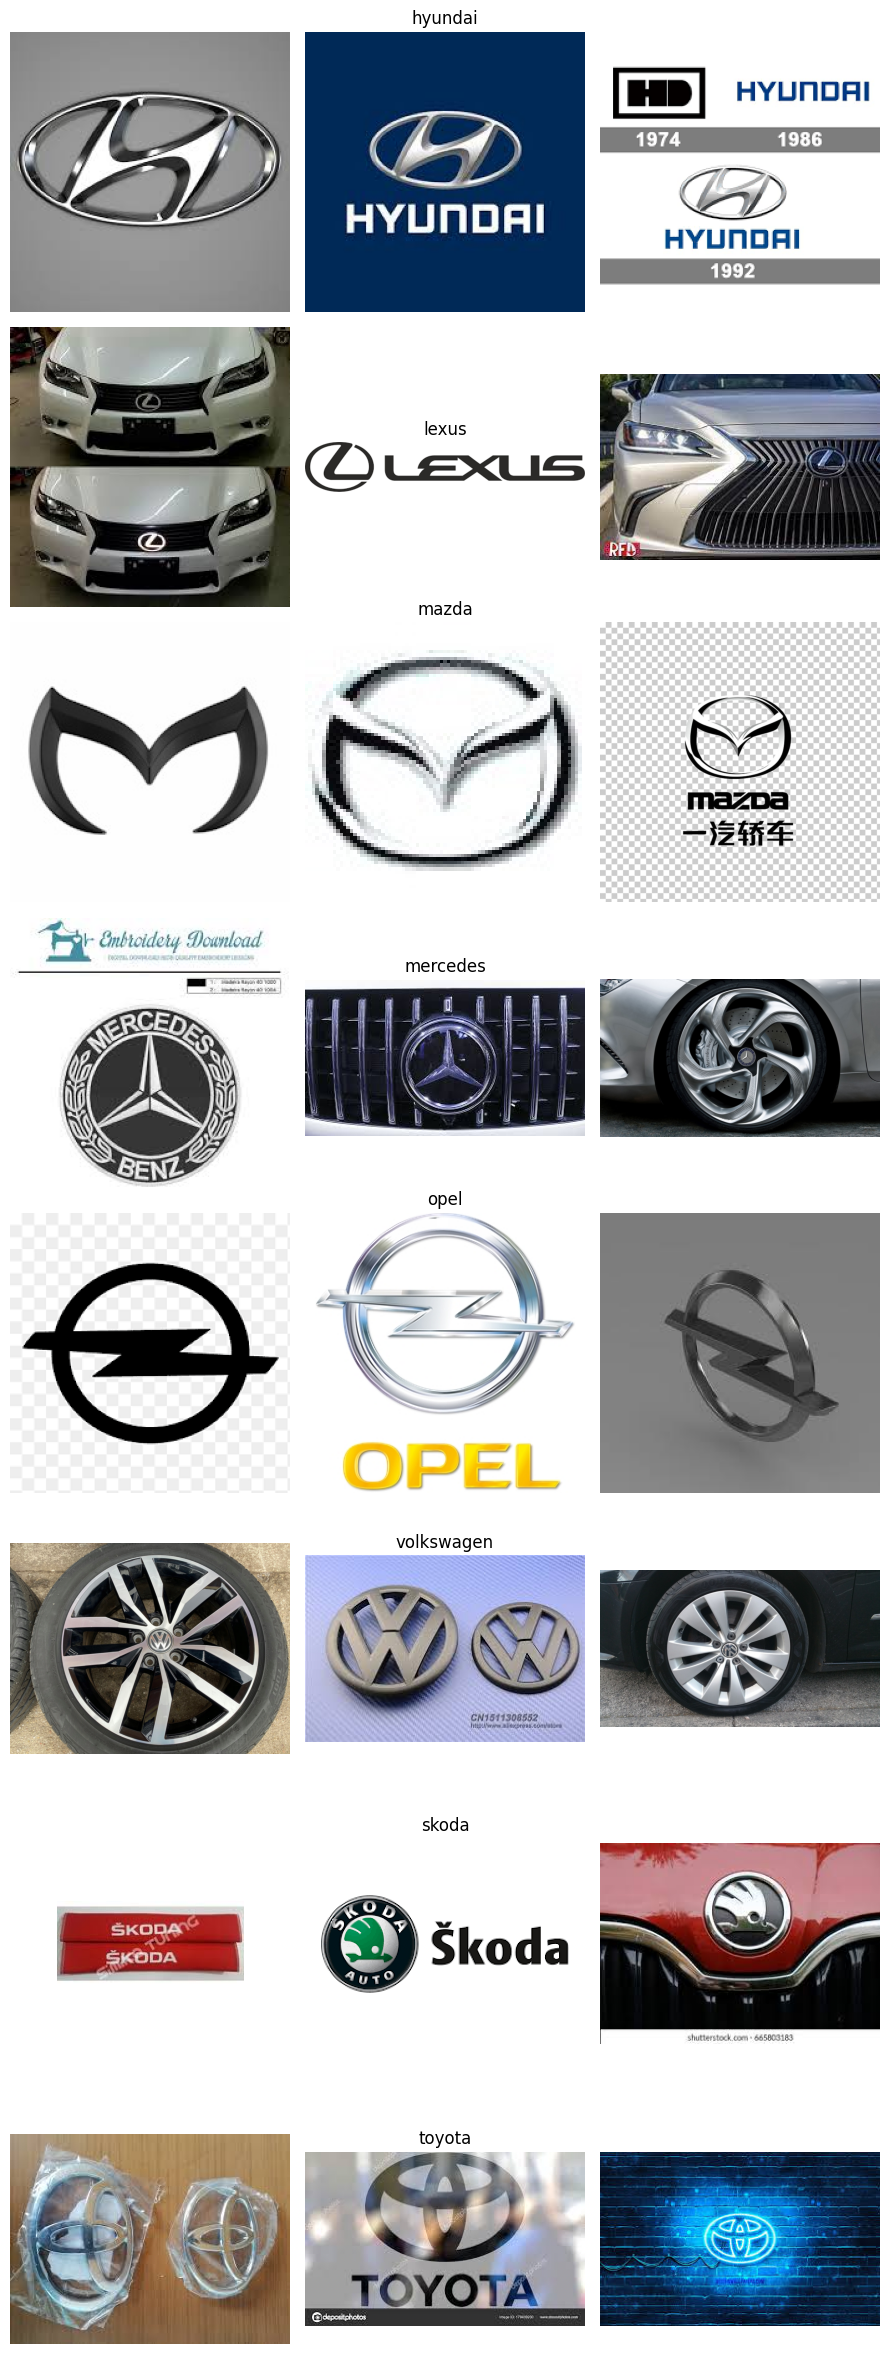

In [19]:
# Visualizing classes
class_names = os.listdir(train_dir)
plt.figure(figsize=(3 * 3, len(class_names) * 3))
for i, cls in enumerate(class_names):
    cls_path = os.path.join(train_dir, cls)
    images = [img for img in os.listdir(cls_path) if img.endswith(('.jpg', '.jpeg', '.png'))]
    selected_images = random.sample(images, min(3, len(images)))
    for j, img_name in enumerate(selected_images):
        img_path = os.path.join(cls_path, img_name)
        image = Image.open(img_path).convert('RGB')
        plt.subplot(len(class_names), 3, i * 3 + j + 1)
        plt.imshow(image)
        plt.axis('off')
        if j == 1:
            plt.title(cls)
plt.tight_layout()
plt.show()

In [20]:
def remove_corrupted_images(directory):
  '''
      Recursively scans through a directory and removes corrupted image files.

    Args:
        directory : Path to the directory to scan for corrupted images.

    Returns:
        None: This function performs file operations and prints results rather than returning.
              The count of removed files is printed to stdout.
  '''
  removed = 0
  for subdir, _, files in os.walk(directory):
      for file in files:
          filepath = os.path.join(subdir, file)
          try:
              img = Image.open(filepath)
              img.verify()
          except (IOError, SyntaxError):
              print(f"Removing corrupt image: {filepath}")
              os.remove(filepath)
              removed += 1
  print(f"Total corrupt images removed: {removed}")

In [21]:
remove_corrupted_images(train_dir)
remove_corrupted_images(test_dir)

Total corrupt images removed: 0
Total corrupt images removed: 0


In [22]:
import os
from PIL import Image

def count_image_formats(folder):
  """
  Counts occurrences of different image formats in a directory and its subdirectories.

  Args:
    folder : Path to the directory containing image files to analyze.

  Returns:
    dict: A dictionary where keys are image format strings (e.g., 'JPEG', 'PNG')
          and values are counts of each format found in the directory.
  """
  formats = {}
  for root, _, files in os.walk(folder):
      for file in files:
          try:
              with Image.open(os.path.join(root, file)) as img:
                  fmt = img.format
                  formats[fmt] = formats.get(fmt, 0) + 1
          except:
              continue
  return formats

# Usage
train_formats = count_image_formats(train_dir)
test_formats = count_image_formats(test_dir)

print("Training formats:", train_formats)
print("Validation formats:", test_formats)

Training formats: {'JPEG': 2256, 'PNG': 246}
Validation formats: {'JPEG': 369, 'PNG': 30}


In [23]:
import os
from PIL import Image
import numpy as np

def collect_image_sizes(root_dir):
  """
  Collects width and height dimensions of all images in a directory and its subdirectories.

  Args:
      root_dir : Path to the root directory containing image files to analyze.

  Returns:
      tuple: Two numpy arrays containing widths and heights of all valid images found.
              Returns empty arrays if no valid images were processed.
  """
  widths, heights = [], []
  image_count = 0
  for folder, _, files in os.walk(root_dir):
      for fname in files:
          if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
              path = os.path.join(folder, fname)
              try:
                  with Image.open(path) as img:
                      w, h = img.size
                      widths.append(w)
                      heights.append(h)
                  image_count += 1
              except Exception as e:
                  print(f"Error processing file {fname}: {e}")

  if image_count == 0:
      print("No images were processed.")
      return np.array([]), np.array([])

  return np.array(widths), np.array(heights)

w, h = collect_image_sizes(train_dir)

if w.size > 0 and h.size > 0:
    print(f"Widths:  min={w.min()}, max={w.max()}, mean={w.mean():.1f}")
    print(f"Heights: min={h.min()}, max={h.max()}, mean={h.mean():.1f}")
else:
    print("No valid image sizes were found.")

Widths:  min=64, max=6000, mean=532.6
Heights: min=64, max=4000, mean=403.1


### Data augmentation and data distribution

In [ ]:
targetSize = (224, 224) #Target Size for resizing
batch_size = 32
num_classes = 8
validation_split = 0.2 #20% for validation

In [ ]:
# Configures real-time data augmentation for image data in training dataset.
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 10,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    zoom_range = 0.05,
    horizontal_flip = True,
    validation_split = 0.2
)


In [ ]:
#  Distributing data and normalizing
training_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size = targetSize,
    batch_size = batch_size,
    class_mode = 'sparse',
    shuffle = True,
    seed = 123,
    subset = "training"
)

validation_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size = targetSize,
    batch_size = batch_size,
    class_mode = 'sparse',
    shuffle = False,
    seed = 123,
    subset = "validation"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_dataset = test_datagen.flow_from_directory(
    test_dir,
    target_size=targetSize,
    batch_size=32,
    class_mode='sparse',
    shuffle=False,
    seed=123
)

Found 2013 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 400 images belonging to 8 classes.


In [ ]:
training_dataset.class_indices.items()

dict_items([('hyundai', 0), ('lexus', 1), ('mazda', 2), ('mercedes', 3), ('opel', 4), ('skoda', 5), ('toyota', 6), ('volkswagen', 7)])

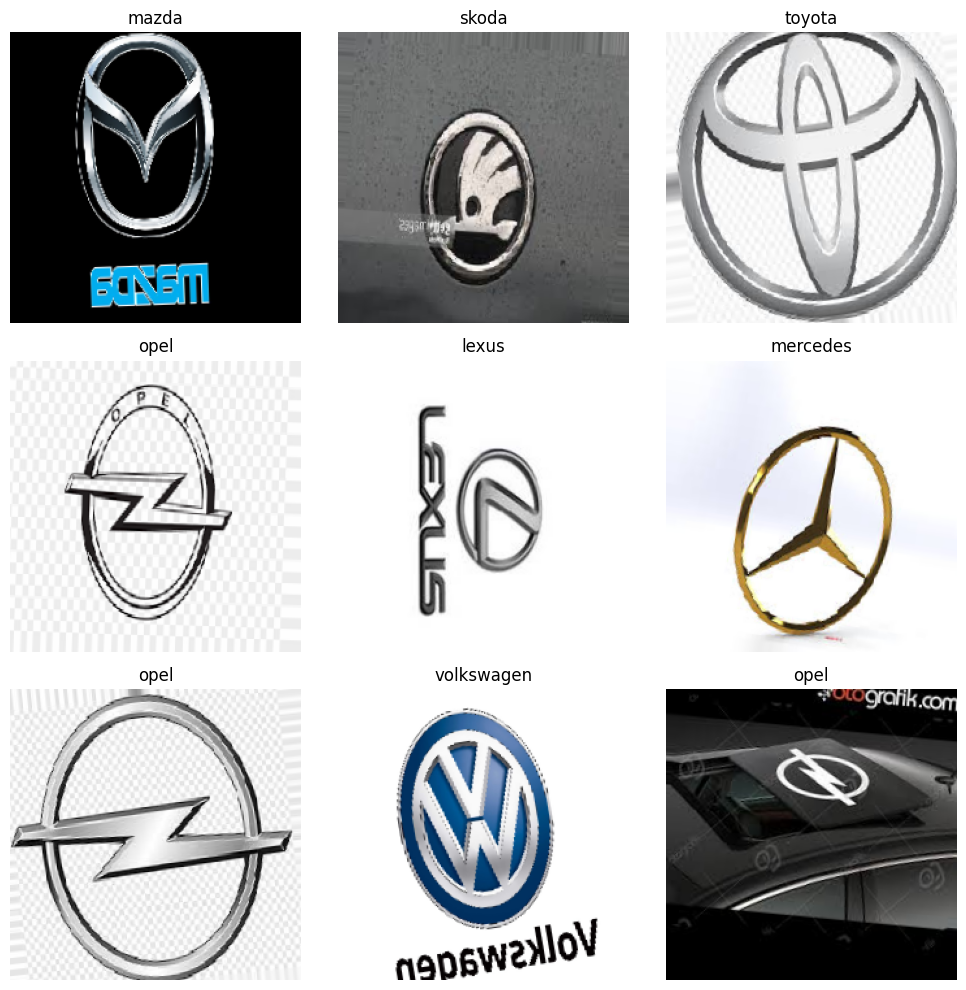

In [ ]:
# Displaying augmented data from the training dataset
class_names = {}
for class_name, class_index in training_dataset.class_indices.items():
    class_names[class_index] = class_name
images, labels = next(training_dataset)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(f"{class_names[int(labels[i])]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### Baseline Model

In [ ]:
# Baseline Model Architecture
input_shape = (224, 224, 3)
num_classes = 8

baseline_adam_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

baseline_adam_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,179,560 (42.65 MB)

 Trainable params: 11,179,560 (42.65 MB)

 Non-trainable params: 0 (0.00 B)

The Convolutional Neural Network (CNN) model is designed for 8-class classification. It consists of three convolutional layers followed by max pooling layers to extract and reduce spatial features. After the convolutional blocks, the output is flattened and passed through four dense (fully connected) layers.

The total number of parameters is around 11.18 million, with the vast majority concentrated in the first dense layer after flattening, which significantly increases the model size and risk of overfitting. All parameters are trainable, and the model occupies about 42.65 MB in memory.

In [ ]:
# Compiling the model
baseline_adam_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Defining callbacks
callbacks = [
    ModelCheckpoint("baseline_adam_best.keras", save_best_only=True, monitor="val_accuracy", mode="max"),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
]

# Training the model
history_baseline_adam = baseline_adam_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=50,
    batch_size=batch_size,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.1209 - loss: 2.3215 - val_accuracy: 0.1260 - val_loss: 2.0737
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 887ms/step - accuracy: 0.1861 - loss: 2.0439 - val_accuracy: 0.2180 - val_loss: 1.9958
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 850ms/step - accuracy: 0.2718 - loss: 1.9320 - val_accuracy: 0.3620 - val_loss: 1.7526
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 813ms/step - accuracy: 0.4495 - loss: 1.6329 - val_accuracy: 0.4560 - val_loss: 1.5137
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 77s 738ms/step - accuracy: 0.5191 - loss: 1.3984 - val_accuracy: 0.4860 - val_loss: 1.4923
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 712ms/step - accuracy: 0.5682 - loss: 1.2430 - val_accuracy: 0.5500 - val_loss: 1.3253
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 714ms/step - accuracy: 0.6080 - loss: 1.1320 - val_accuracy: 0.5420 - val_loss: 1.4014
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 889ms/step - accuracy: 0.6484 - loss: 1.0584 - val_accurac

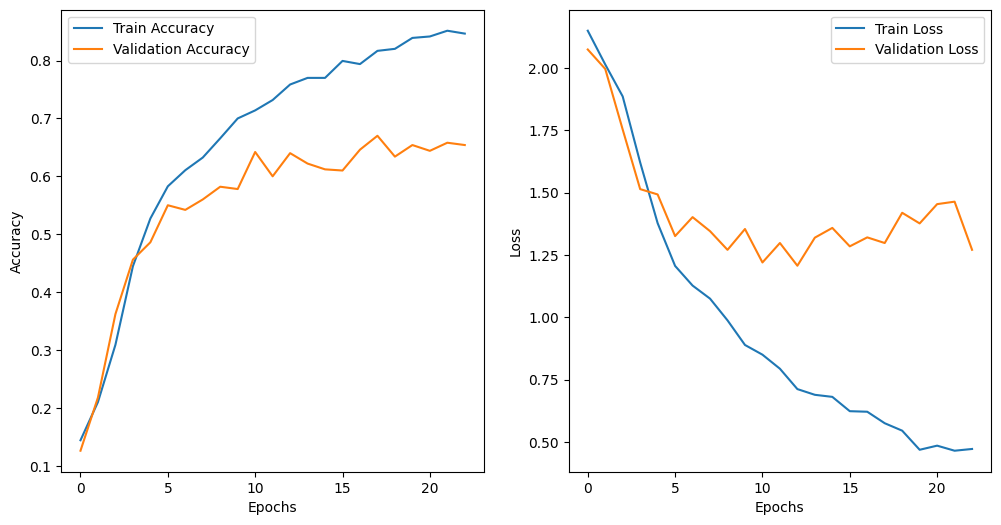

In [ ]:
# Plotting traning and validation curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_baseline_adam.history['accuracy'], label='Train Accuracy')
plt.plot(history_baseline_adam.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_baseline_adam.history['loss'], label='Train Loss')
plt.plot(history_baseline_adam.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
#  Predicting the model in test data
baseline_test_loss, baseline_test_accuracy = baseline_adam_model.evaluate(test_dataset)

print(f"Test Loss: {baseline_test_loss:.4f}")
print(f"Test Accuracy: {baseline_test_accuracy:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - accuracy: 0.6247 - loss: 1.6127
Test Loss: 1.5264
Test Accuracy: 0.6075


In [ ]:
# Classification report
y_true = test_dataset.classes
y_pred_probs = baseline_adam_model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

class_names = list(test_dataset.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_names))

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step
              precision    recall  f1-score   support

     hyundai       0.62      0.60      0.61        50
       lexus       0.43      0.52      0.47        50
       mazda       0.82      0.80      0.81        50
    mercedes       0.54      0.70      0.61        50
        opel       0.63      0.52      0.57        50
       skoda       0.62      0.62      0.62        50
      toyota       0.66      0.46      0.54        50
  volkswagen       0.63      0.64      0.63        50

    accuracy                           0.61       400
   macro avg       0.62      0.61      0.61       400
weighted avg       0.62      0.61      0.61       400



13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step


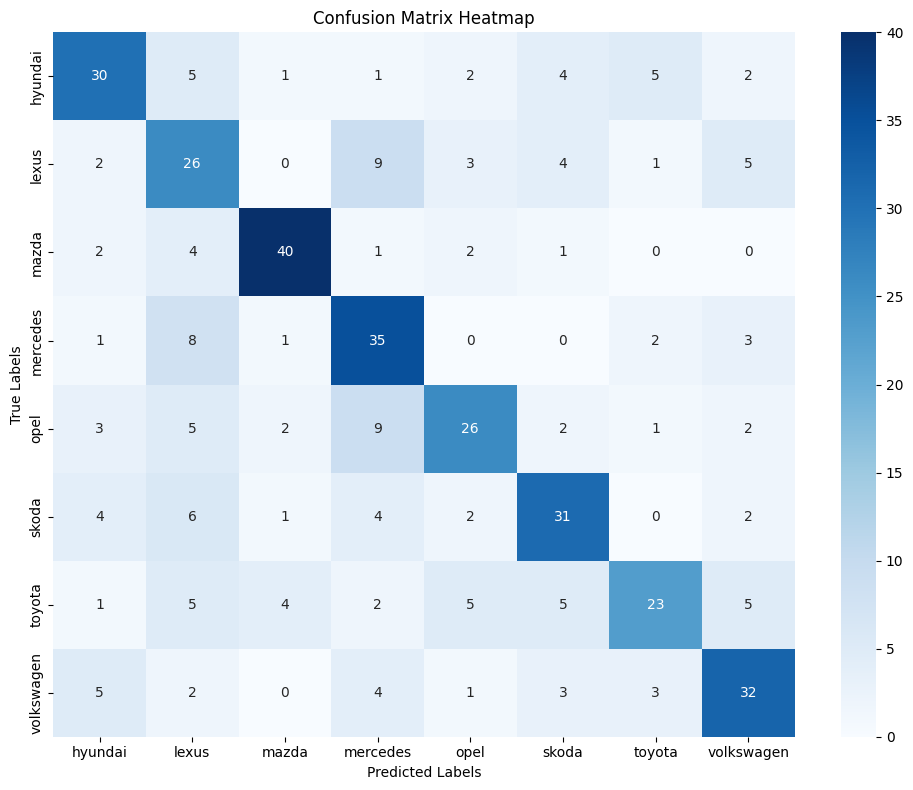

In [ ]:
# Confusion matrix
y_true = test_dataset.classes
y_pred_probs = baseline_adam_model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=test_dataset.class_indices.keys(),
            yticklabels=test_dataset.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


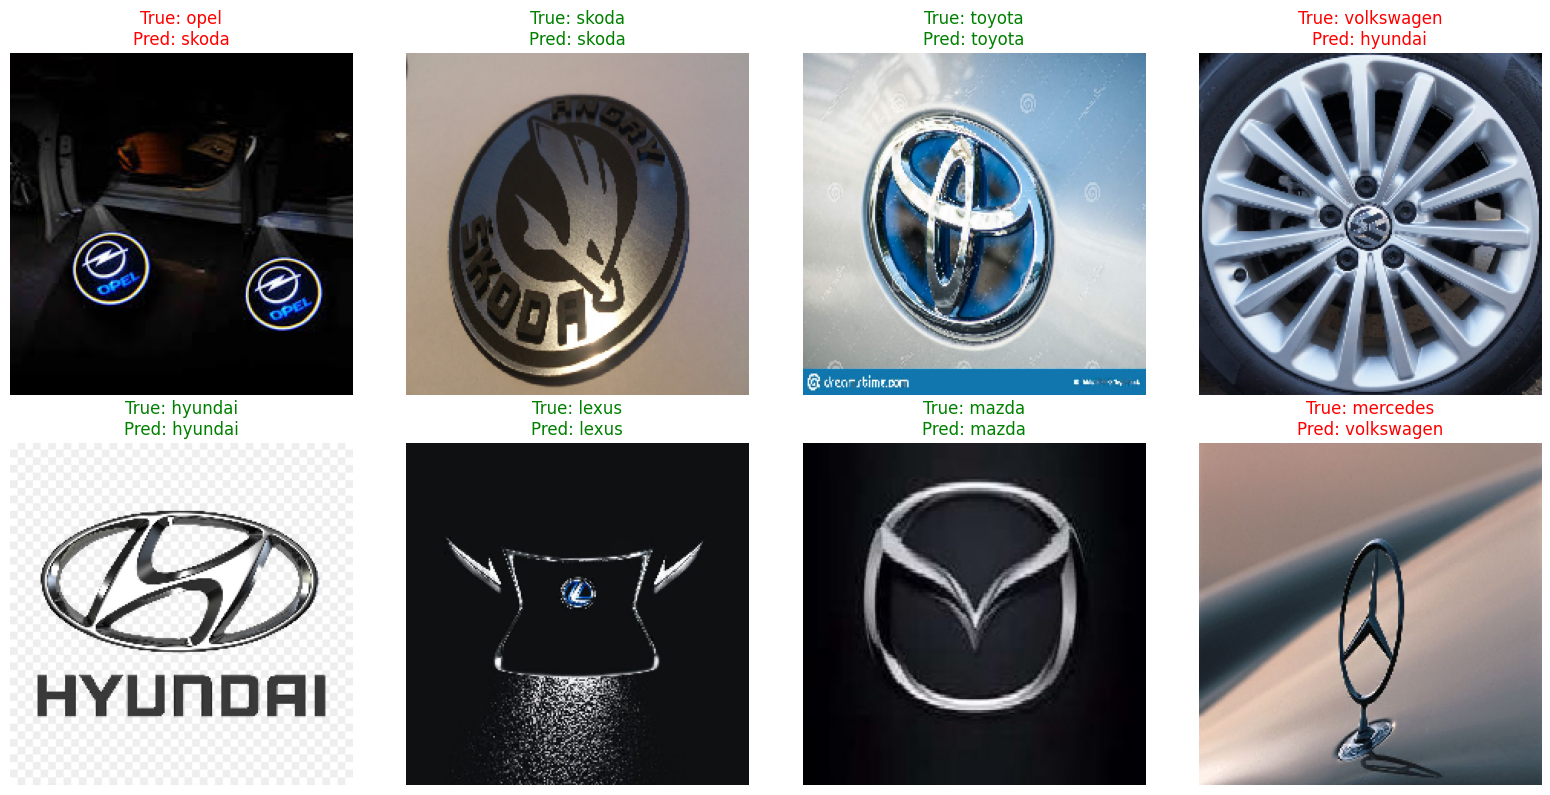


Sample Prediction Accuracy: 5/8 (62.5%)


In [ ]:
sample_images = []
sample_labels = []
found_classes = set()

# Collect one image per class from the test generator
for images, labels in test_dataset:
    for img, lbl in zip(images, labels):
        lbl = int(lbl)  # Convert to integer class index
        if lbl not in found_classes:
            sample_images.append(img)
            sample_labels.append(lbl)
            found_classes.add(lbl)
            if len(found_classes) == num_classes:
                break
    if len(found_classes) == num_classes:
        break

# Convert to numpy arrays
sample_images = np.array(sample_images)
sample_labels = np.array(sample_labels)

# Make predictions
sample_preds = baseline_adam_model.predict(sample_images)
predicted_classes = np.argmax(sample_preds, axis=1)

# Determine grid layout based on number of classes
n_cols = 4
n_rows = min(2, (num_classes + n_cols - 1) // n_cols)

# Create the plot
plt.figure(figsize=(16, 8))
for i in range(len(sample_images)):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(sample_images[i])
    true_name = class_names[sample_labels[i]]
    pred_name = class_names[predicted_classes[i]]
    color = 'green' if true_name == pred_name else 'red'
    plt.title(f"True: {true_name}\nPred: {pred_name}", color=color)
    plt.axis('off')

# Handle case where we have empty subplots
for i in range(len(sample_images), n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print classification accuracy on these samples
correct = sum(predicted_classes == sample_labels)
print(f"\nSample Prediction Accuracy: {correct}/{len(sample_labels)} ({correct/len(sample_labels):.1%})")

- Discuss key observations about model performance.

  - The model has a moderate overall accuracy of 61%, performing best on Mazda, with strong precision and recall. Volkswagen and Skoda also show relatively good results. However, it struggles with Lexus and Toyota, often confusing Lexus with Mercedes and misclassifying Toyota images.

  - The confusion matrix reveals overlapping predictions, especially among visually similar brands. This suggests the model has difficulty distinguishing certain features. Improving feature extraction, using a deeper network, or applying regularization could enhance performance.

### Deeper Model with sgd optimizer

In [ ]:
from tensorflow.keras.regularizers import l2

input_shape = (224, 224, 3)
num_classes = 8

deeper_sgd_model = Sequential([
    # Block 1 - Increased filters and added L2 regularization
    Conv2D(64, (3, 3), activation='relu', padding='same',
          input_shape=input_shape, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),  # Added dropout after each block

    # Block 2 - Increased depth
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Block 3 - Additional convolutional layer
    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Block 4 - Additional block for deeper architecture
    Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Classification block
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dense(num_classes, activation='softmax')
])

deeper_sgd_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_57 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 56,210,248 (214.43 MB)

 Trainable params: 56,204,872 (214.40 MB)

 Non-trainable params: 5,376 (21.00 KB)

This model is deep and well-structured, starting with multiple convolutional and batch normalization layers, followed by pooling and dropout to reduce overfitting. It progressively increases filters from 64 to 512, then flattens the output and uses dense layers for classification.

The model has over 56 million parameters, with the majority in the fully connected layers, especially the first dense layer. Batch normalization is applied throughout, improving stability and convergence. Overall, this architecture is powerful and suitable for complex image classification tasks.

In [ ]:
# Compiling the model
optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

deeper_sgd_model.compile(optimizer=optimizer,
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])


In [ ]:
# Enhanced callbacks
callbacks_sgd = [
    ModelCheckpoint("deeper_sgd_best.keras", save_best_only=True, monitor="val_accuracy", mode="max"),
    EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6)
]

history_deeper_sgd = deeper_sgd_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=callbacks_sgd
)


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.1386 - loss: 5.6554 - val_accuracy: 0.1240 - val_loss: 5.8124 - learning_rate: 0.0010
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 832ms/step - accuracy: 0.2143 - loss: 5.2556 - val_accuracy: 0.1200 - val_loss: 5.2756 - learning_rate: 0.0010
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 61s 975ms/step - accuracy: 0.2657 - loss: 5.0419 - val_accuracy: 0.1440 - val_loss: 5.7117 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 935ms/step - accuracy: 0.3162 - loss: 4.8891 - val_accuracy: 0.1500 - val_loss: 5.6404 - learning_rate: 0.0010
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.3561 - loss: 4.7767 - val_accuracy: 0.1920 - val_loss: 5.4277 - learning_rate: 0.0010
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.3967 - loss: 4.6500 - val_accuracy: 0.2740 - val_loss: 5.1500 - learning_rate: 0.0010
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 61s 976ms/step - accuracy: 0.4321 - loss: 4.5804 - v

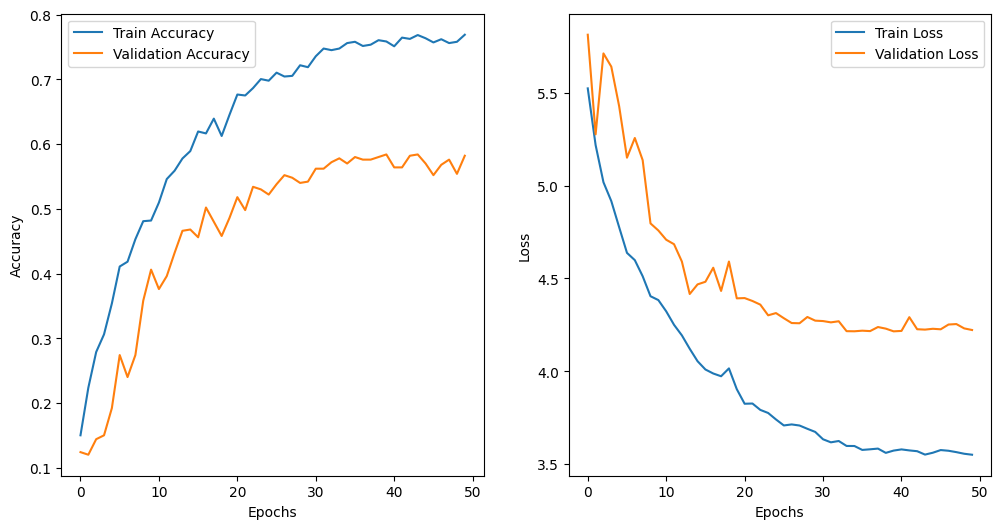

In [ ]:
# Plot the training and validatin curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_deeper_sgd.history['accuracy'], label='Train Accuracy')
plt.plot(history_deeper_sgd.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_deeper_sgd.history['loss'], label='Train Loss')
plt.plot(history_deeper_sgd.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
deeper_sgd_test_loss, deeper_sgd_test_accuracy = deeper_sgd_model.evaluate(test_dataset)

print(f"Test Loss: {deeper_sgd_test_loss:.4f}")
print(f"Test Accuracy: {deeper_sgd_test_accuracy:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 290ms/step - accuracy: 0.6452 - loss: 3.9788
Test Loss: 4.1378
Test Accuracy: 0.6075


In [ ]:
y_true = test_dataset.classes
y_pred_probs = deeper_sgd_model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

class_names = list(test_dataset.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_names))

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 258ms/step
              precision    recall  f1-score   support

     hyundai       0.56      0.68      0.61        50
       lexus       0.47      0.46      0.46        50
       mazda       0.61      0.80      0.69        50
    mercedes       0.45      0.74      0.56        50
        opel       0.75      0.60      0.67        50
       skoda       0.75      0.60      0.67        50
      toyota       0.91      0.40      0.56        50
  volkswagen       0.74      0.58      0.65        50

    accuracy                           0.61       400
   macro avg       0.65      0.61      0.61       400
weighted avg       0.65      0.61      0.61       400



13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 260ms/step


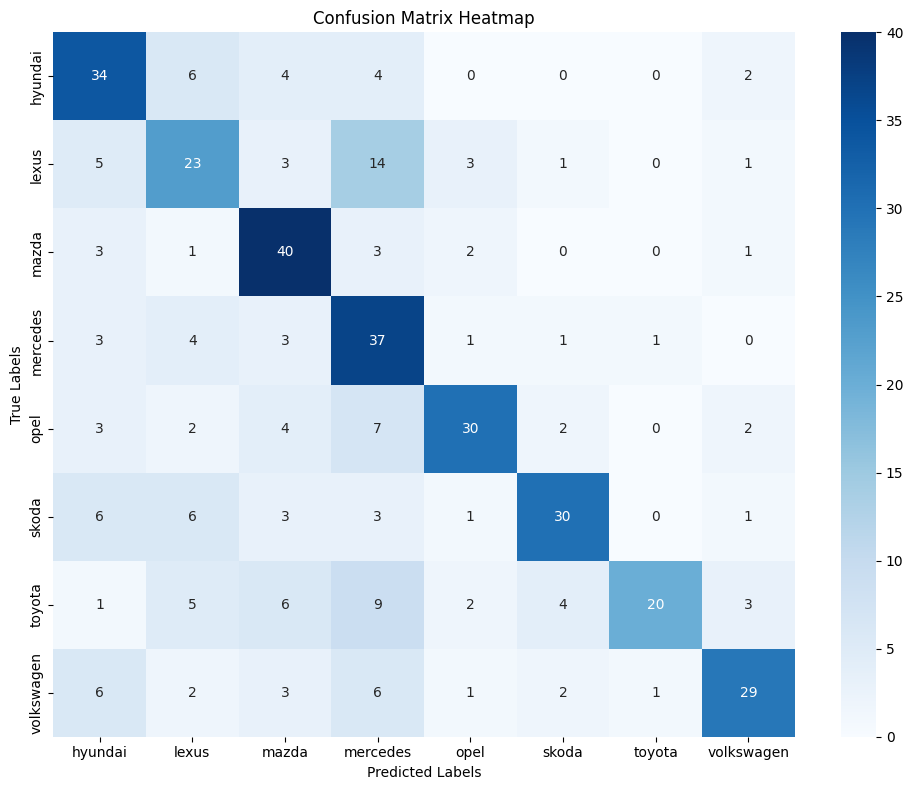

In [ ]:
y_true = test_dataset.classes
y_pred_probs = deeper_sgd_model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=test_dataset.class_indices.keys(),
            yticklabels=test_dataset.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


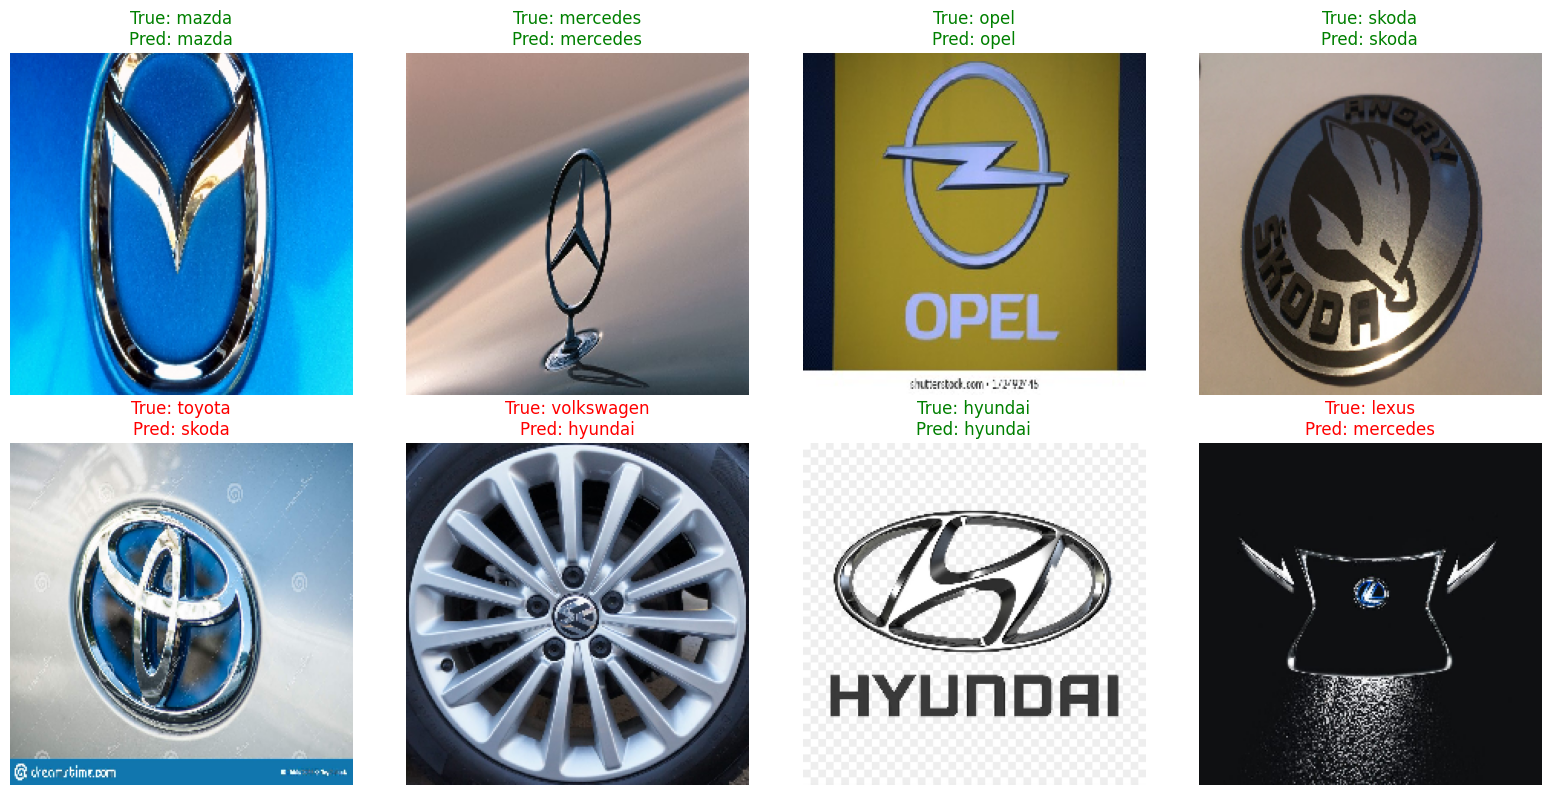


Sample Prediction Accuracy: 5/8 (62.5%)


In [ ]:
# Initialize storage for sample images and labels
sample_images = []
sample_labels = []
found_classes = set()

# Collect one image per class from the test generator
for images, labels in test_dataset:
    for img, lbl in zip(images, labels):
        lbl = int(lbl)  # Convert to integer class index
        if lbl not in found_classes:
            sample_images.append(img)
            sample_labels.append(lbl)
            found_classes.add(lbl)
            if len(found_classes) == num_classes:
                break
    if len(found_classes) == num_classes:
        break

# Convert to numpy arrays
sample_images = np.array(sample_images)
sample_labels = np.array(sample_labels)

# Make predictions using deeper_sgd_model
sample_preds = deeper_sgd_model.predict(sample_images)
predicted_classes = np.argmax(sample_preds, axis=1)

# Determine grid layout based on number of classes
n_cols = 4
n_rows = min(2, (num_classes + n_cols - 1) // n_cols)

# Create the plot
plt.figure(figsize=(16, 8))
for i in range(len(sample_images)):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(sample_images[i])
    true_name = class_names[sample_labels[i]]
    pred_name = class_names[predicted_classes[i]]
    color = 'green' if true_name == pred_name else 'red'
    plt.title(f"True: {true_name}\nPred: {pred_name}", color=color)
    plt.axis('off')

# Handle case where we have empty subplots
for i in range(len(sample_images), n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print classification accuracy on these samples
correct = sum(predicted_classes == sample_labels)
print(f"\nSample Prediction Accuracy: {correct}/{len(sample_labels)} ({correct/len(sample_labels):.1%})")

- Discuss improvements (or lack thereof) compared to the baseline model.

  - The updated model shows a mixed performance compared to the baseline, maintaining the same overall accuracy of 61% but with notable variations in class-specific metrics. Improvements are evident for mazda, which saw a significant rise in precision (0.82) and F1-score (0.81), indicating better differentiation from other classes. Similarly, mercedes achieved a more balanced precision-recall trade-off (0.54 precision, 0.70 recall), reducing false positives. However, the model still struggles with lexus and toyota, where precision and recall remain low, suggesting persistent confusion, likely due to overlapping features in these classes. For instance, toyota's recall dropped to 0.46, with frequent misclassifications as lexus or skoda. The deeper architecture and SGD optimizer may not be sufficient to address these challenges, as the model fails to consistently improve across all classes.

### Deeper model with adam optimizer

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

input_shape = (224, 224, 3)
num_classes = 8

deeper_adam_model = Sequential([
    # Block 1 - with regularization
    Conv2D(32, (3, 3), activation='relu', padding='same',
          input_shape=input_shape, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    # Block 4
    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    # Block 5
    Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.4),

    # Classification block
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

deeper_adam_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_65 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 17,702,184 (67.53 MB)

 Trainable params: 17,696,680 (67.51 MB)

 Non-trainable params: 5,504 (21.50 KB)

This model is deep and well-structured, starting with multiple convolutional and batch normalization layers, followed by pooling and dropout to reduce overfitting. It progressively increases filters from 64 to 512, then flattens the output and uses dense layers for classification.

The model has over 56 million parameters, with the majority in the fully connected layers, especially the first dense layer. Batch normalization is applied throughout, improving stability and convergence. Overall, this architecture is powerful and suitable for complex image classification tasks.

In [ ]:
deeper_adam_model.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

In [ ]:
callbacks_adam = [
    ModelCheckpoint("deeper_adam_best.keras", save_best_only=True, monitor="val_accuracy", mode="max"),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6)
]

history_deeper_adam = deeper_adam_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=callbacks_adam
)


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.1522 - loss: 6.4226 - val_accuracy: 0.1400 - val_loss: 9.9481 - learning_rate: 0.0010
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 774ms/step - accuracy: 0.1772 - loss: 6.4047 - val_accuracy: 0.1280 - val_loss: 6.9761 - learning_rate: 0.0010
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 57s 913ms/step - accuracy: 0.1970 - loss: 6.0499 - val_accuracy: 0.1180 - val_loss: 5.9401 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 749ms/step - accuracy: 0.1860 - loss: 5.8573 - val_accuracy: 0.1100 - val_loss: 5.8947 - learning_rate: 0.0010
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.2111 - loss: 5.5080 - val_accuracy: 0.1560 - val_loss: 5.3883 - learning_rate: 0.0010
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 881ms/step - accuracy: 0.2483 - loss: 5.2635 - val_accuracy: 0.2080 - val_loss: 5.1253 - learning_rate: 0.0010
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 754ms/step - accuracy: 0.2694 - loss: 5.0100 -

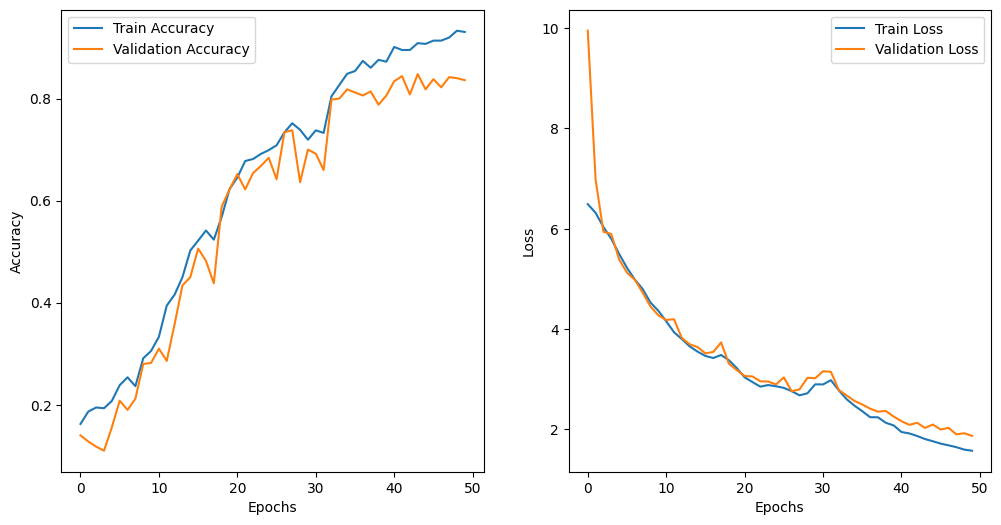

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_deeper_adam.history['accuracy'], label='Train Accuracy')
plt.plot(history_deeper_adam.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_deeper_adam.history['loss'], label='Train Loss')
plt.plot(history_deeper_adam.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
deeper_adam_test_loss, deeper_adam_test_accuracy = deeper_adam_model.evaluate(test_dataset)

print(f"Test Loss: {deeper_adam_test_loss:.4f}")
print(f"Test Accuracy: {deeper_adam_test_accuracy:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 291ms/step - accuracy: 0.8231 - loss: 2.0116
Test Loss: 2.1693
Test Accuracy: 0.7950


In [ ]:
y_true = test_dataset.classes
y_pred_probs = deeper_adam_model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

class_names = list(test_dataset.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_names))

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 259ms/step
              precision    recall  f1-score   support

     hyundai       0.71      0.78      0.74        50
       lexus       0.79      0.92      0.85        50
       mazda       0.95      0.80      0.87        50
    mercedes       0.85      0.88      0.86        50
        opel       0.75      0.72      0.73        50
       skoda       0.83      0.78      0.80        50
      toyota       0.94      0.60      0.73        50
  volkswagen       0.67      0.88      0.76        50

    accuracy                           0.80       400
   macro avg       0.81      0.80      0.79       400
weighted avg       0.81      0.80      0.79       400



13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 323ms/step


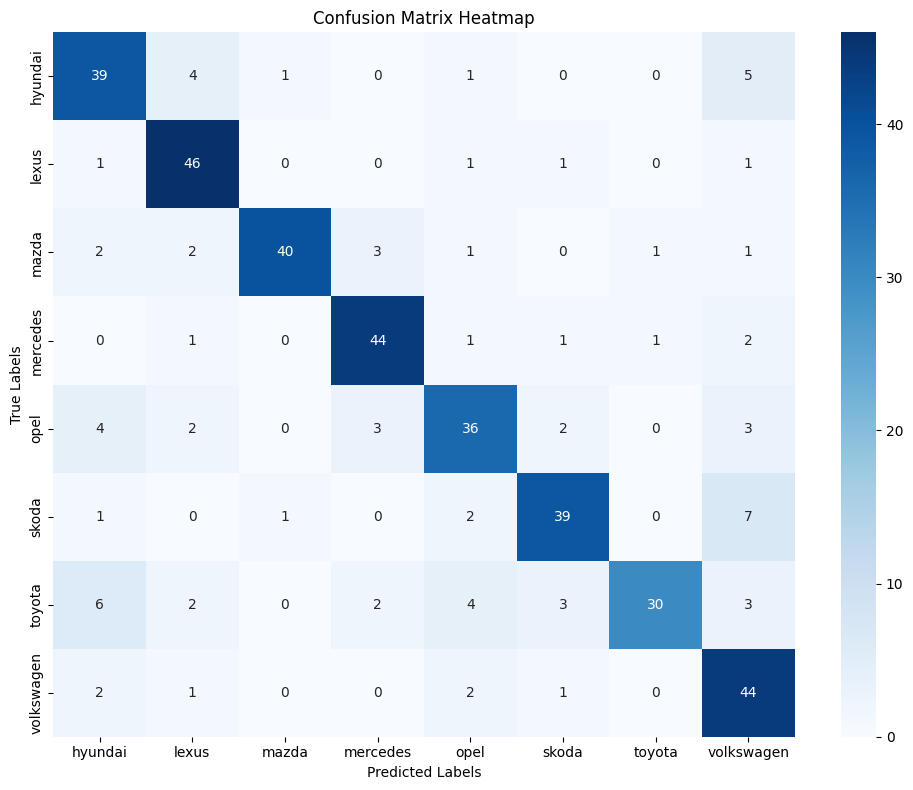

In [ ]:
y_true = test_dataset.classes
y_pred_probs = deeper_adam_model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=test_dataset.class_indices.keys(),
            yticklabels=test_dataset.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


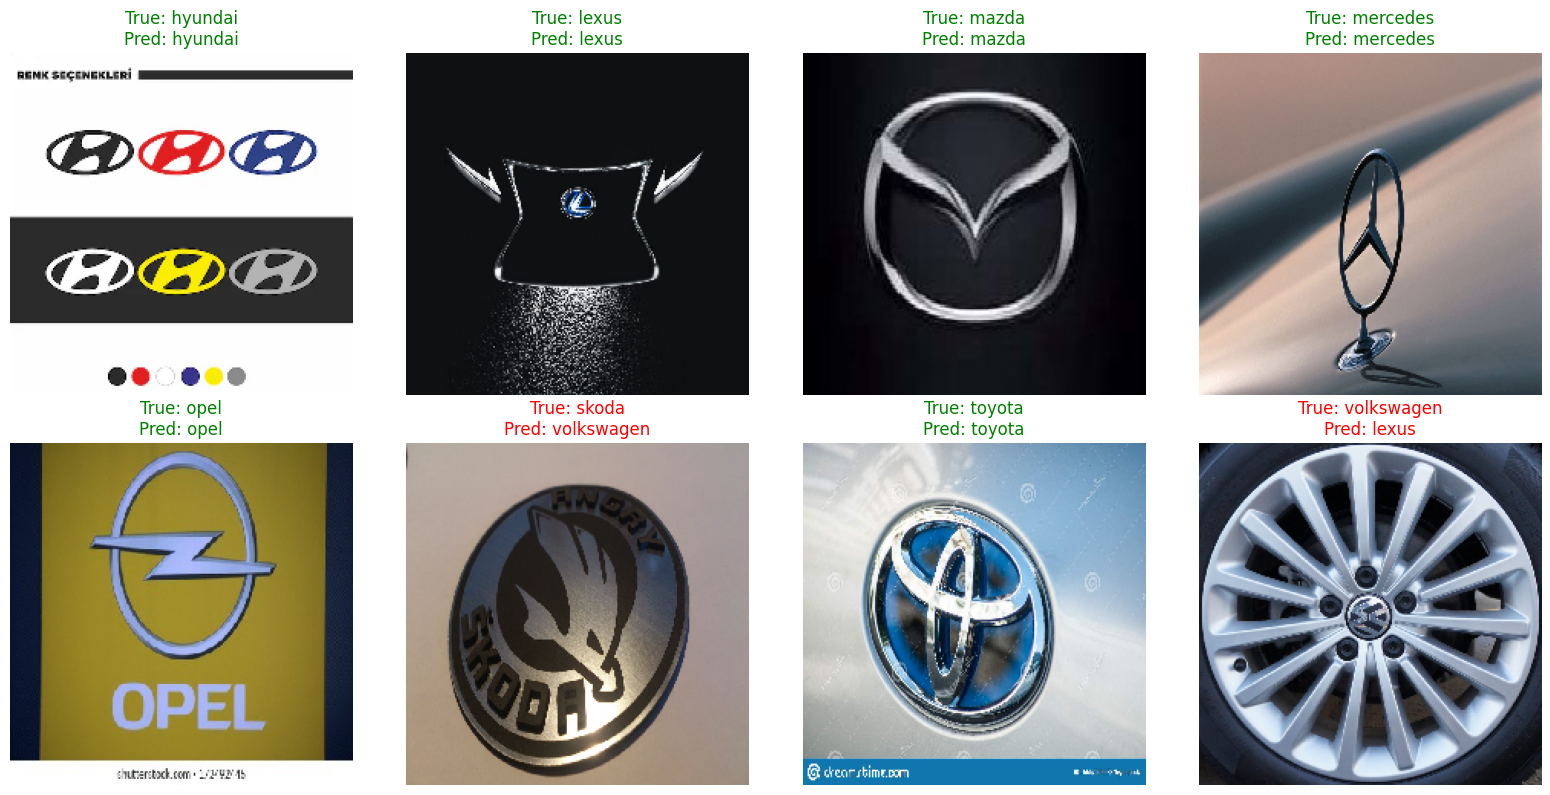


Sample Prediction Accuracy: 6/8 (75.0%)


In [ ]:
# Initialize storage for sample images and labels
sample_images = []
sample_labels = []
found_classes = set()

# Collect one image per class from the test generator
for images, labels in test_dataset:
    for img, lbl in zip(images, labels):
        lbl = int(lbl)  # Convert to integer class index
        if lbl not in found_classes:
            sample_images.append(img)
            sample_labels.append(lbl)
            found_classes.add(lbl)
            if len(found_classes) == num_classes:
                break
    if len(found_classes) == num_classes:
        break

# Convert to numpy arrays
sample_images = np.array(sample_images)
sample_labels = np.array(sample_labels)

# Make predictions using deeper_adam_model
sample_preds = deeper_adam_model.predict(sample_images)
predicted_classes = np.argmax(sample_preds, axis=1)

# Determine grid layout based on number of classes
n_cols = 4
n_rows = min(2, (num_classes + n_cols - 1) // n_cols)  # Max 2 rows

# Create the plot
plt.figure(figsize=(16, 8))
for i in range(len(sample_images)):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(sample_images[i])
    true_name = class_names[sample_labels[i]]
    pred_name = class_names[predicted_classes[i]]
    color = 'green' if true_name == pred_name else 'red'
    plt.title(f"True: {true_name}\nPred: {pred_name}", color=color)
    plt.axis('off')

# Handle case where we have empty subplots
for i in range(len(sample_images), n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print classification accuracy on these samples
correct = sum(predicted_classes == sample_labels)
print(f"\nSample Prediction Accuracy: {correct}/{len(sample_labels)} ({correct/len(sample_labels):.1%})")

- Discuss improvements (or lack thereof) compared to the baseline model.

  - The Adam version of the model shows impressive progress compared to the original baseline. The initial model achieved only 61% accuracy and struggled with inconsistent performance across classes, while the improved version now hits 80% accuracy with more balanced results. The biggest improvements are seen in previously challenging categories. Lexus recognition improved from an F1 score of 0.47 to 0.85, Mazda jumped from 0.69 to 0.87, and Mercedes went from 0.56 to 0.86. These gains mainly came from switching the optimizer to Adam compared to sdg and architecture compared to baseline model, which made training more stable and improved results.

  - While the model still occasionally confuses similar-looking vehicles like Toyotas and Volkswagens, it now makes fewer mistakes. The overall improvement across all vehicle classes shows that the changes in both optimization and architecture worked together to turn what was once an average classifier into a much more reliable system.

### Experimentation and Comparative Analysis:


1. Baseline vs. Deeper Model Performance:

- **Baseline Model (Adam):** The baseline model achieved an overall accuracy of 0.61 on the test set, with precision, recall, and F1-score averaging 0.62, 0.61, and 0.61, respectively. The training accuracy rises steadily to around 0.85 after 20 epochs, but validation accuracy plateaus at 0.65, indicating potential overfitting. Training loss drops to 0.5, while validation loss fluctuates around 1.25, further suggesting overfitting.

- **Deeper Model (Adam):** The deeper model significantly improves performance, achieving an overall accuracy of 0.80, with precision, recall, and F1-score averaging 0.81, 0.80, and 0.79, respectively. The training accuracy reaches 0.95 after 50 epochs, with validation accuracy stabilizing at 0.75. Training loss decreases to ~0.1, and validation loss stabilizes around 0.75, showing better generalization than the baseline.

- **Baseline:** The confusion matrix shows reasonable performance, with diagonal values (correct predictions) ranging from 20 to 40. However, there are notable misclassifications, e.g., 14 lexus samples are predicted as mercedes, and toyota has a low recall (0.46).

- **Deeper Model:** The deeper model’s confusion matrix shows improved performance, with higher diagonal values (30 to 46). Misclassifications are reduced, e.g., lexus prediction improves significantly (46 correct), though toyota still has a lower recall (0.60).


- Adding more convolutional layers (from 3 to 5), increasing filters (up to 512), and incorporating batch normalization and dropout in the deeper model improved performance. The deeper model better captures complex features, leading to a 19% accuracy increase (0.61 to 0.80). However, validation accuracy and loss indicate some overfitting, though less severe than the baseline.

2. Computational Efficiency :

- **Baseline Model:** Took 21 minutes to train on a T4 GPU (Google Colab) for 50 epochs.

- **Deeper Model (Adam):** Took 45 minutes to train for 50 epochs on the same T4 GPU. The deeper model has more layers (5 Conv2D vs. 3), more filters (up to 512 vs. 128), and additional batch normalization and dropout layers, increasing the parameter count from 11.18M to 17.70M.

- **Deeper Model (SGD):** Took 50 minutes for 50 epochs, slightly longer than Adam, likely due to slower convergence.

- The deeper model’s improved accuracy (0.80 vs. 0.61) comes at the cost of increased computational complexity and training time (45 minutes vs. 21 minutes). The additional layers and parameters (17.70M vs. 11.18M) make the deeper model more resource-intensive, which may be a bottleneck for deployment on resource-constrained devices. However, the performance gain justifies the added complexity for applications prioritizing accuracy.

3. Optimizer Analysis: SGD vs Adam :

- **Adam Optimizer:** Adam converges faster, with training accuracy reaching ~0.95 and validation accuracy stabilizing at ~0.75 after 50 epochs. Training loss drops to ~0.1, and validation loss stabilizes at ~0.75. Final accuracy is 0.80, with a macro F1-score of 0.79. The confusion matrix shows strong performance across most classes.

- **SGD Optimizer:** SGD shows slower convergence, with training accuracy reaching ~0.80 and validation accuracy plateauing at ~0.65 after 50 epochs. Training loss decreases to ~1.0, but validation loss fluctuates around 1.5, suggesting less stable training. Final accuracy is 0.61, with a macro F1-score of 0.61. The confusion matrix shows more misclassifications, e.g., toyota recall drops to 0.40.


- Adam outperforms SGD in both convergence speed and final performance. Adam’s adaptive learning rate allows faster and more stable convergence, achieving a 19% higher accuracy (0.80 vs. 0.61). SGD struggles with slower convergence and higher validation loss, indicating it may require more epochs or hyperparameter tuning (e.g., learning rate, momentum) to match Adam’s performance.

4. Challenges and Observations :

- **Baseline Model:** The training accuracy (0.85) significantly exceeds validation accuracy (0.65), and validation loss (1.25) remains high while training loss (0.5) decreases, indicating clear overfitting.
- **Deeper Model (Adam):** Overfitting is reduced compared to the baseline. Validation accuracy (0.75) is closer to training accuracy (0.95), and validation loss (0.75) is lower. However, some overfitting persists, likely due to the model’s complexity. Batch normalization and dropout help mitigate this, but further regularization (e.g., weight decay) might improve generalization.
- **Deeper Model (SGD):** Similar overfitting issues are observed, with a larger gap between training (0.80) and validation accuracy (0.65). Validation loss (1.5) fluctuates more than with Adam, indicating less stable training.

- Training was performed on Google Colab using a T4 GPU, which provided sufficient acceleration for the models. The T4 GPU handled the increased computational load of the deeper model well, though training time doubled compared to the baseline.

## Part B: Fine-Tuning a Pre-Trained Model (Transfer Learning).

### Transfer Learning

In [ ]:
input_shape = (224, 224, 3)
num_classes = 8

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
# Load VGG16 without the top classification layer
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(224, 224, 3)
                   )

# Freeze all layers
base_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Add layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [ ]:
transfer_model = Model(inputs=base_model.input, outputs=predictions)
transfer_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 14,781,384 (56.39 MB)

 Trainable params: 66,696 (260.53 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
transfer_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("transfer_dar_model.keras", save_best_only=True, monitor="val_accuracy", mode="max"),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5)
]

history_transfer = transfer_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 758s 12s/step - accuracy: 0.1471 - loss: 2.2629 - val_accuracy: 0.3460 - val_loss: 1.9441 - learning_rate: 0.0010
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 733ms/step - accuracy: 0.2388 - loss: 1.9887 - val_accuracy: 0.4740 - val_loss: 1.7690 - learning_rate: 0.0010
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 717ms/step - accuracy: 0.3435 - loss: 1.8393 - val_accuracy: 0.5360 - val_loss: 1.6242 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 738ms/step - accuracy: 0.4026 - loss: 1.6674 - val_accuracy: 0.6100 - val_loss: 1.4501 - learning_rate: 0.0010
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 719ms/step - accuracy: 0.4601 - loss: 1.5817 - val_accuracy: 0.6460 - val_loss: 1.3424 - learning_rate: 0.0010
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 730ms/step - accuracy: 0.4907 - loss: 1.5037 - val_accuracy: 0.6360 - val_loss: 1.2538 - learning_rate: 0.0010
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 714ms/step - accuracy: 0.5198 - loss: 1.4

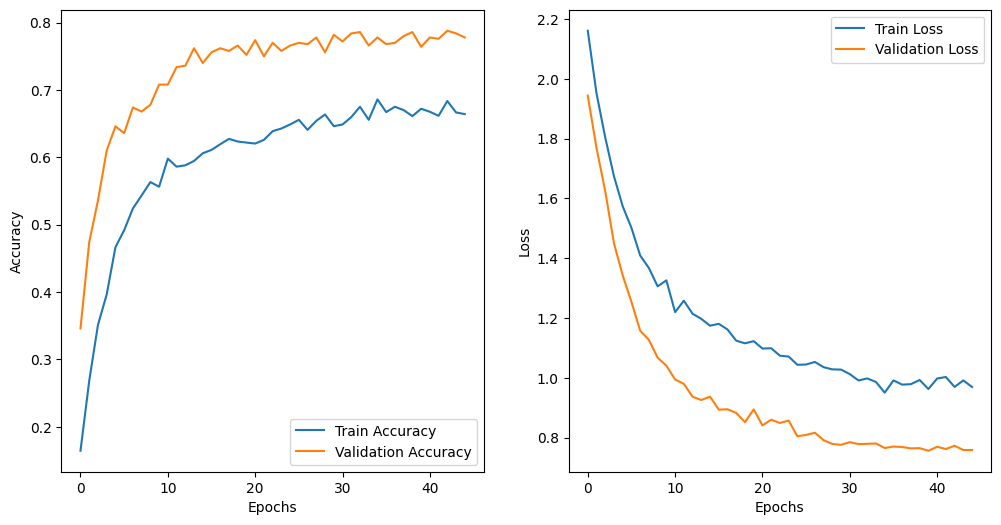

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='Train Accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='Train Loss')
plt.plot(history_transfer.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Unfreeze last 20 layers
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

transfer_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
transfer_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 14,781,384 (56.39 MB)

 Trainable params: 14,781,384 (56.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_finetune = transfer_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.7068 - loss: 0.8487 - val_accuracy: 0.8720 - val_loss: 0.4931 - learning_rate: 1.0000e-05
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 833ms/step - accuracy: 0.8209 - loss: 0.5427 - val_accuracy: 0.8760 - val_loss: 0.4396 - learning_rate: 1.0000e-05
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 825ms/step - accuracy: 0.8559 - loss: 0.4486 - val_accuracy: 0.8840 - val_loss: 0.4053 - learning_rate: 1.0000e-05
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 811ms/step - accuracy: 0.8695 - loss: 0.3761 - val_accuracy: 0.8800 - val_loss: 0.3981 - learning_rate: 1.0000e-05
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 52s 828ms/step - accuracy: 0.8998 - loss: 0.3172 - val_accuracy: 0.8980 - val_loss: 0.3723 - learning_rate: 1.0000e-05
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 815ms/step - accuracy: 0.9121 - loss: 0.2699 - val_accuracy: 0.8960 - val_loss: 0.3710 - learning_rate: 1.0000e-05
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 52s 823ms/step - accur

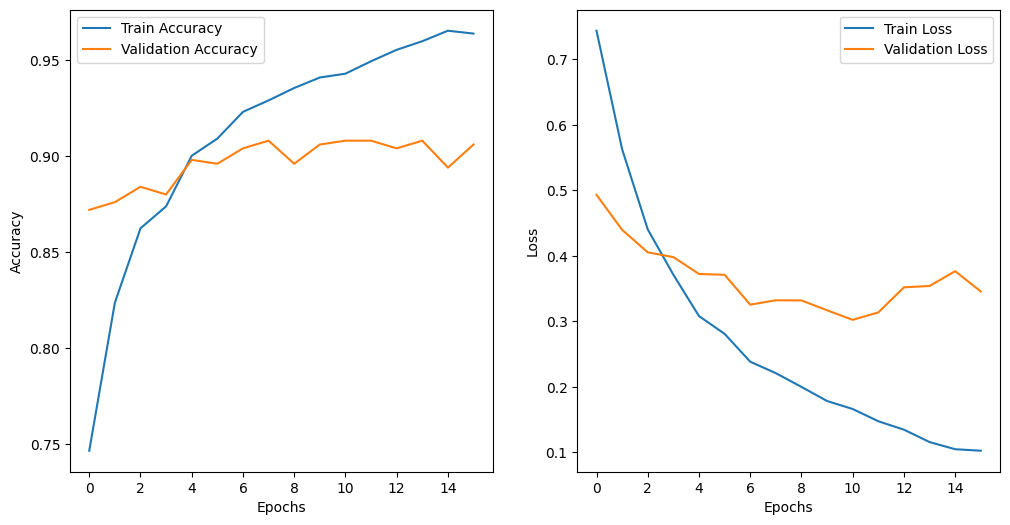

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['loss'], label='Train Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
fine_tune_test_loss, fine_tune_test_accuracy = transfer_model.evaluate(test_dataset)
print(f"Test Accuracy: {fine_tune_test_accuracy*100:.2f}%")
print(f"Test Loss: {fine_tune_test_loss:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 120s 10s/step - accuracy: 0.8756 - loss: 0.4852
Test Accuracy: 85.75%
Test Loss: 0.5583


In [ ]:
y_true = test_dataset.classes
y_pred_probs = transfer_model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

class_names = list(test_dataset.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_names))

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step
              precision    recall  f1-score   support

     hyundai       0.89      0.82      0.85        50
       lexus       0.79      0.96      0.86        50
       mazda       0.88      0.90      0.89        50
    mercedes       0.80      0.94      0.86        50
        opel       0.93      0.78      0.85        50
       skoda       0.83      0.86      0.84        50
      toyota       0.89      0.78      0.83        50
  volkswagen       0.91      0.82      0.86        50

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400



13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 278ms/step


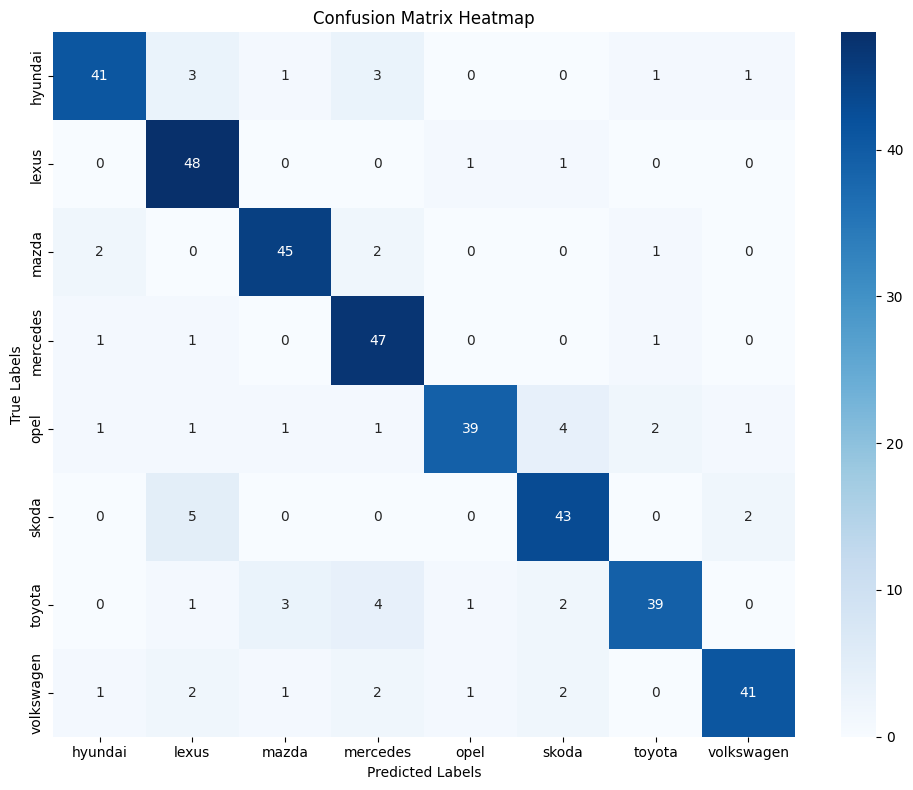

In [ ]:
y_true = test_dataset.classes
y_pred_probs = transfer_model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=test_dataset.class_indices.keys(),
            yticklabels=test_dataset.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.tight_layout()
plt.show()

Compared to the other two models, transfer learning model’s validation accuracy starts high, above 0.85, remains stable throughout training and eventually reaches above 0.90 and the validation loss also declines from a very low number of 0.5 to below 0.4. The overall accuracy increases of the model to 0.86 which is highest among all three models.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


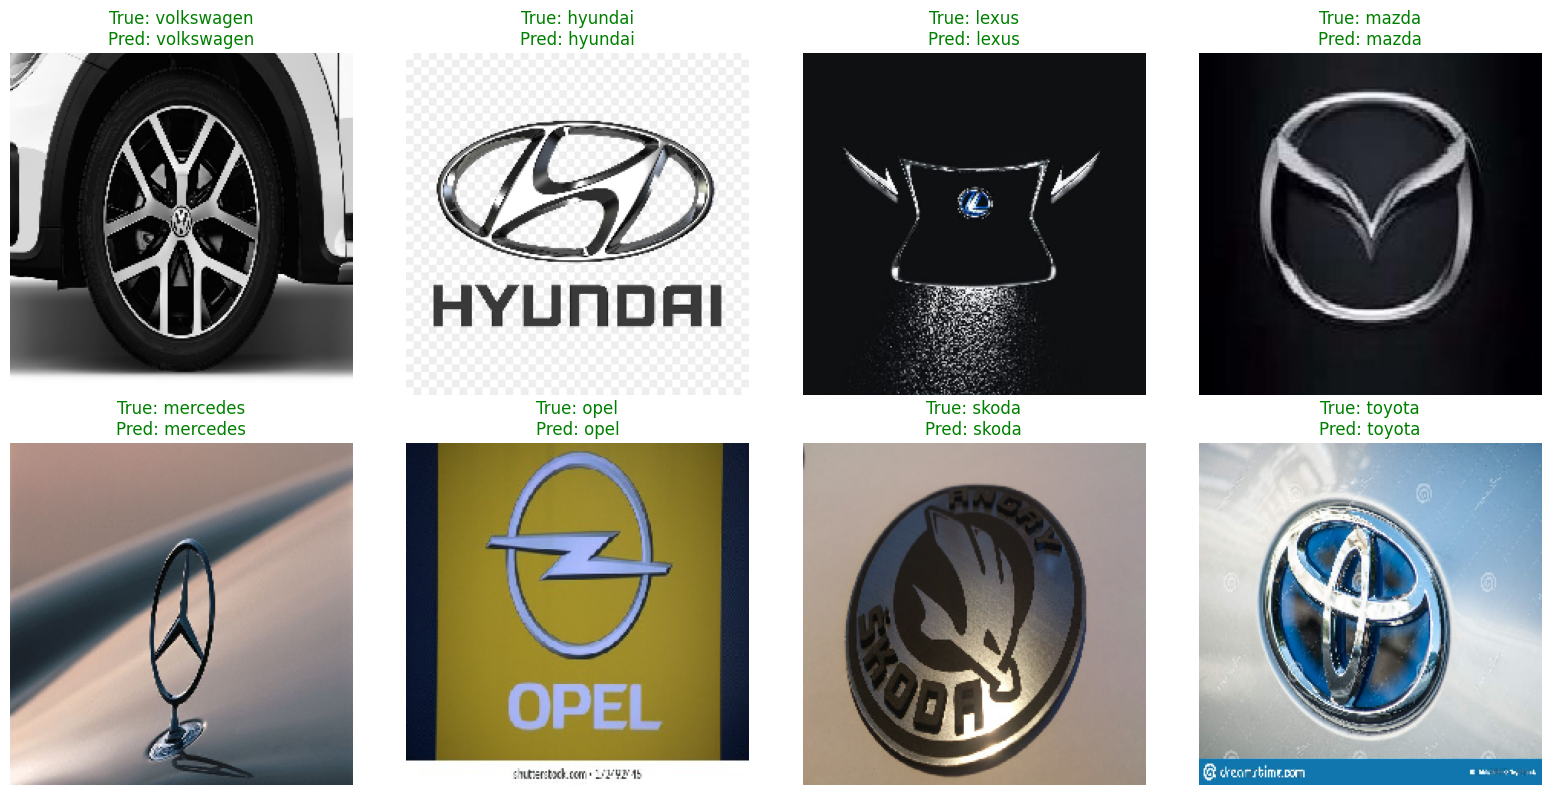


Sample Prediction Accuracy: 8/8 (100.0%)


In [ ]:
# Initialize storage for sample images and labels
sample_images = []
sample_labels = []
found_classes = set()

# Collect one image per class from the test generator
for images, labels in test_dataset:
    for img, lbl in zip(images, labels):
        lbl = int(lbl)  # Convert to integer class index
        if lbl not in found_classes:
            sample_images.append(img)
            sample_labels.append(lbl)
            found_classes.add(lbl)
            if len(found_classes) == num_classes:
                break
    if len(found_classes) == num_classes:
        break

# Convert to numpy arrays
sample_images = np.array(sample_images)
sample_labels = np.array(sample_labels)

# Make predictions using deeper_adam_model
sample_preds = transfer_model.predict(sample_images)
predicted_classes = np.argmax(sample_preds, axis=1)

# Determine grid layout based on number of classes
n_cols = 4
n_rows = min(2, (num_classes + n_cols - 1) // n_cols)

# Create the plot
plt.figure(figsize=(16, 8))
for i in range(len(sample_images)):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(sample_images[i])
    true_name = class_names[sample_labels[i]]
    pred_name = class_names[predicted_classes[i]]
    color = 'green' if true_name == pred_name else 'red'
    plt.title(f"True: {true_name}\nPred: {pred_name}", color=color)
    plt.axis('off')

# Handle case where we have empty subplots
for i in range(len(sample_images), n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print classification accuracy on these samples
correct = sum(predicted_classes == sample_labels)
print(f"\nSample Prediction Accuracy: {correct}/{len(sample_labels)} ({correct/len(sample_labels):.1%})")